In [ ]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
import re
import cv2
from sklearn.model_selection import train_test_split

print(tf.__version__)


2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_folder = 'drive/MyDrive/rawData'
sub_folder_list = os.listdir(input_folder)
data_images_with_labels = []
data_images = []
data_labels = []
for i in range(len(sub_folder_list)):
    if sub_folder_list[i]=='bowPlaying':
        int_label = 0
    if sub_folder_list[i]=='notPlaying':
        int_label = 1
    if sub_folder_list[i]=='colLegno':
        int_label = 2
    if sub_folder_list[i]=='pizz':
        int_label = 3
    #print(os.path.join(input_folder,sub_folder_list[i]))
    images_list = os.listdir(os.path.join(input_folder,sub_folder_list[i]))
    #print(images_list)
    images_list.sort(key=lambda f: int(re.sub('\D', '', f)))
    #print(images_list)
    for j in range(len(images_list)):
        img_rgb = cv2.imread(os.path.join(input_folder,sub_folder_list[i],images_list[j]))
        img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
        # ABOVE LINE CONVERTS TO GREYSCALE
        #data_images_with_labels.append([img,sub_folder_list[i]])
        data_images.append(img)
        
        data_labels.append(int_label)


X_train, X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.33, random_state=42)
train_images = np.asarray(X_train, dtype=None, order=None)
test_images = np.asarray(X_test, dtype=None, order=None)
train_labels = np.asarray(y_train, dtype=None, order=None)
test_labels = np.asarray(y_test, dtype=None, order=None)

In [ ]:
"""# Helper Functions"""

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
print(train_images.shape)
print(train_labels[3])

class_names = ['bowPlaying', 'notPlaying', 'colLegno', 'pizz']

"""## Explore the data"""

train_images.shape

len(train_labels)

np.unique(train_labels)


(1208, 240, 320)
0


array([0, 1, 2, 3])

In [ ]:
"""# Test Dataset"""

test_images.shape

len(test_labels)


596

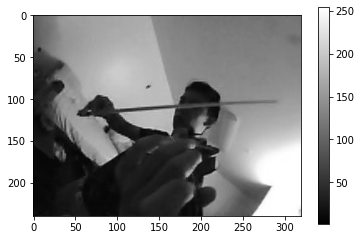

In [ ]:
"""## Preprocessing"""

train_img = train_images[2]
plt.figure()
plt.imshow(train_images[2], cmap="gray")
# plt.imshow(train_images[2])
plt.colorbar()
plt.grid(False)
plt.show()
#
train_images = train_images / 255.0
test_images = test_images / 255.0


In [ ]:
"""## Build & Compile the model

"""

model = keras.Sequential([
    Flatten(input_shape=(240, 320, 1)), 
    Dense(64, activation='relu'), #still confused on what more dense layers does
    Dense(4) #this
])

model.summary()

model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)

KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"

model.save(KERAS_MODEL_NAME)

convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

keras_model_size = get_file_size(KERAS_MODEL_NAME)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 76800)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4915264   
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,915,524
Trainable params: 4,915,524
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
38/38 [==============================] - 2s 35ms/step - loss: 6.1156 - accuracy: 0.5447
Epoch 2/10
38/38 [==============================] - 1s 35ms/step - loss: 0.3449 - accuracy: 0.8733
Epoch 3/10
38/38 [==============================] - 1s 35ms/step - loss: 0.3497 - accuracy: 0.8543
Epoch 4/10


In [ ]:
"""# TF Lite Model"""

TF_LITE_MODEL_FILE_NAME = "tf_lite_model_jul20.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

INFO:tensorflow:Assets written to: /tmp/tmpi2igptc8/assets


INFO:tensorflow:Assets written to: /tmp/tmpi2igptc8/assets


File size: 19202.816 Kilobytes


In [ ]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 240, 320, 1) #1 instead of 3
        yield [data.astype(np.float32)]

# Convert the tflite.
converter = lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
with open('tf_lite_model_quantized.tflite', 'wb') as f:
  f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmpjuau1r4s/assets


INFO:tensorflow:Assets written to: /tmp/tmpjuau1r4s/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


264
prediction is: 1
0 
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 3
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
prediction is: 1
0
predict

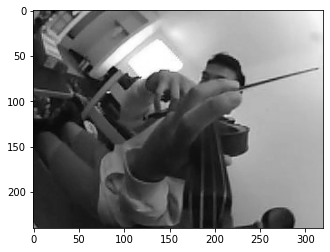

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])


  # test_folder = 'drive/MyDrive/test'
  test_folder = 'drive/MyDrive/rawData/pizz'
  test_images = os.listdir(test_folder)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i in range(len(test_images)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image_rgb = cv2.imread(os.path.join(test_folder,test_images[i]))
    test_image = cv2.cvtColor(test_image_rgb, cv2.COLOR_BGR2GRAY)
    # print(test_image)
    # print(interpreter.get_input_details())
    plt.imshow(test_image, cmap="gray")
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    test_image = np.expand_dims(test_image, axis=3).astype(np.float32) #4 dimensions i think is fucking it up


    # print(test_image.shape)
    # print(interpreter.get_input_details())
    # print(input_tensor_index)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels (txt) to calculate accuracy.
  def readFile(fileName):
      fileObj = open(fileName, "r") #opens the file in read mode
      words = fileObj.read().splitlines() #puts the file into an array
      fileObj.close()
      return words

  test_labels = readFile('drive/MyDrive/test_labels.txt')

  accurate_count = 0
  print(len(prediction_digits))
  for index in range(len(prediction_digits)):
    print('prediction is: ' + str(prediction_digits[index]))
    print(test_labels[index])
    if str(prediction_digits[index]) == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy



# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
newaccuracy = evaluate_tflite_model(tflite_model)
print('Float model accuracy = %.4f' % newaccuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

# quantized_accuracy = evaluate_tflite_model(tflite_quant_model)
# print('Quantized model accuracy = %.4f' % quantized_accuracy)
# print('Accuracy drop = %.4f' % (newaccuracy - quantized_accuracy))

